# Advanced CNN Training

## Imports

In [1]:

import os
import sys
from pathlib import Path

import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from typing import Dict, Optional


repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from utils.gtzan_legacy import generate_stratified_split, create_dataloaders_from_split, GENRES
from utils.advanced_cnn import AdvancedCNN, SpecAugment, augment_waveform_batch


In [2]:
def mixup_data(x: torch.Tensor, y: torch.Tensor, alpha: float = 0.1):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Training helpers

In [3]:
def train_one_epoch(
    model,
    train_loader,
    optimizer,
    criterion,
    scaler,
    device,
    sample_rate,
    mixup_alpha: float = 0.1,
    grad_clip: float = 2.5,
    augment_kwargs=None,
):
    model.train()
    augment_kwargs = augment_kwargs or {}

    total_loss = 0.0
    total_correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc='Train Advanced'):
        # inputs: (B, 1, T)
        inputs = augment_waveform_batch(
            inputs.to(device),
            sample_rate,
            training=True,
            **augment_kwargs,
        )

        labels = labels.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, mixup_alpha)

        optimizer.zero_grad()

        with autocast(device.type == 'cuda'):
            outputs = model(inputs)
            if lam != 1.0:
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                loss = criterion(outputs, targets_a)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * labels.size(0)
        total += labels.size(0)
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()

    return total_loss / total, 100 * total_correct / total

def evaluate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validate'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            total += labels.size(0)
            total_correct += (outputs.argmax(dim=1) == labels).sum().item()

    return total_loss / total, 100 * total_correct / total



In [4]:


def train_model_advanced(
    model,
    train_loader,
    val_loader,
    num_epochs: int,
    base_lr: float,
    device,
    mixup_alpha: float = 0.2,
    weight_decay: float = 5e-4,
    max_shift_seconds: float = 0.8,
    noise_std: float = 0.0005,
    crop_seconds: float = 15.0,
    save_path: Optional[str] = '../models/gtzan_advanced_cnn.pth',
    early_stopping_patience: int = 10,
):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=base_lr,
        weight_decay=weight_decay,
        betas=(0.9, 0.99),
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=base_lr * 0.1,
    )
    scaler = GradScaler(enabled=device.type == 'cuda')

    history: Dict[str, list] = {k: [] for k in ['train_loss', 'train_acc', 'val_loss', 'val_acc']}
    best_val_loss = float('inf')
    patience = 0

    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} — LR: {current_lr:.2e}")

        train_loss, train_acc = train_one_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            scaler,
            device,
            model.sample_rate,
            mixup_alpha=mixup_alpha,
            augment_kwargs={
                'max_shift_seconds': max_shift_seconds,
                'noise_std': noise_std,
                'crop_seconds': crop_seconds,
            },
        )

        val_loss, val_acc = evaluate_epoch(model, val_loader, criterion, device)

        prev_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < prev_lr:
            print(f"ReduceLROnPlateau lowered LR from {prev_lr:.2e} to {new_lr:.2e}")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train loss {train_loss:.3f} | Train acc {train_acc:.2f}%")
        print(f"Val   loss {val_loss:.3f} | Val   acc {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
            if save_path is not None:
                torch.save(model.state_dict(), save_path)
                print(f"Saved best model to {save_path}")
        else:
            patience += 1
            if patience >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    return history


## Example usage on GTZAN

In [5]:
# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

split_path = repo_root / 'data' / 'gtzan_split.json'
if not split_path.exists():
    raise FileNotFoundError(f"Missing split file at {split_path}; run generate_stratified_split first.")

train_loader, val_loader, test_loader = create_dataloaders_from_split(
    root_dir=str(repo_root / 'data' / 'gtzan'),
    split_path=str(split_path),
    batch_size=24,
)

model = AdvancedCNN(
    n_classes=len(GENRES),
    spec_augment=SpecAugment(),
)

history = train_model_advanced(
    model,
    train_loader,
    val_loader,
    num_epochs=60,
    base_lr=3e-4,
    device=device,
    mixup_alpha=0.1,
    weight_decay=5e-4,
    max_shift_seconds=1.0,
    noise_std=0.001,
    crop_seconds=15.0,
    save_path=str(repo_root / 'models' / 'gtzan_advanced_higher_regularization_cnn.pth'),
)




Using device: cuda


C:\Users\mar20\AppData\Local\Temp\ipykernel_13600\1797288402.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=device.type == 'cuda')


Epoch 1/60 — LR: 3.00e-04


Train Advanced:   0%|          | 0/30 [00:00<?, ?it/s]C:\Users\mar20\AppData\Local\Temp\ipykernel_13600\383525359.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(device.type == 'cuda'):
Validate: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Train loss nan | Train acc 9.87%
Val   loss nan | Val   acc 10.00%
Epoch 2/60 — LR: 3.00e-04


Train Advanced:  43%|████▎     | 13/30 [00:05<00:07,  2.21it/s]


KeyboardInterrupt: 

Validate: 100%|██████████| 9/9 [00:01<00:00,  7.09it/s]


Test loss 0.781 | Test acc 80.50%


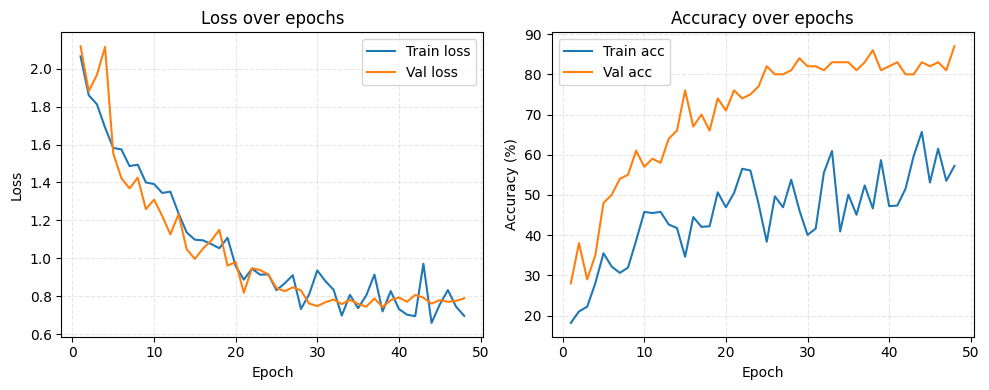

In [ ]:
# Optional test eval
import matplotlib.pyplot as plt

def plot_history(history):
    """
    Plot training & validation loss/accuracy from the history dict returned
    by train_model_advanced().
    """
    # Basic safety checks
    if not history:
        print("History is empty.")
        return

    epochs = range(1, len(history.get('train_loss', [])) + 1)

    plt.figure(figsize=(10, 4))

    # ---- Loss ----
    plt.subplot(1, 2, 1)
    if 'train_loss' in history:
        plt.plot(epochs, history['train_loss'], label='Train loss')
    if 'val_loss' in history:
        plt.plot(epochs, history['val_loss'], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)

    # ---- Accuracy ----
    plt.subplot(1, 2, 2)
    if 'train_acc' in history:
        plt.plot(epochs, history['train_acc'], label='Train acc')
    if 'val_acc' in history:
        plt.plot(epochs, history['val_acc'], label='Val acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()


criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
test_loss, test_acc = evaluate_epoch(model, test_loader, criterion, device)
print(f"Test loss {test_loss:.3f} | Test acc {test_acc:.2f}%")

plot_history(history)